## Introduction

The following notebook explores the possibilities and limitations of the Amazon Bedrock Knowledge Bases Retrieve and Generate API.

### What You'll Learn

By working through this notebook, you will:

1. Understand how to interact with the Bedrock Knowledge Bases Retrieve and Generate API.
2. Learn about default prompt templates and how to customize them.
3. Explore the limitations of custom formatting within the API's constraints.
4. Discover alternative approaches using separate Retrieve and Generate steps for more control.
5. Gain insights into best practices for citation handling and response formatting.

### Prerequisites

To get the most out of this notebook, you should have:

- Basic familiarity with Python and Jupyter notebooks.
- An AWS account with access to Amazon Bedrock services.
- A basic understanding of generative AI and RAG workflows.

Let's begin by laying out some foundational concepts.

## Background

### Key Concepts

1. **Knowledge Bases**: These are collections of information organized for efficient retrieval and use. In the context of Amazon Bedrock, they serve as the foundation for AI-powered question-answering systems.

2. **Retrieve and Generate API**: As the name implies, the Retrieve and Generate API is used to retrieve information from a knowledge base and generate a response. This API combines two crucial steps in the Retrieval Augmented Generation (RAG) workflow:
   - Retrieval: Finding relevant documents or information from the knowledge base.
   - Generation: Using the retrieved information to generate a coherent and contextually appropriate response.

3. **Prompt Templates**: These are pre-defined structures that guide the AI model in generating responses. We'll explore both default and custom prompt templates in this notebook.

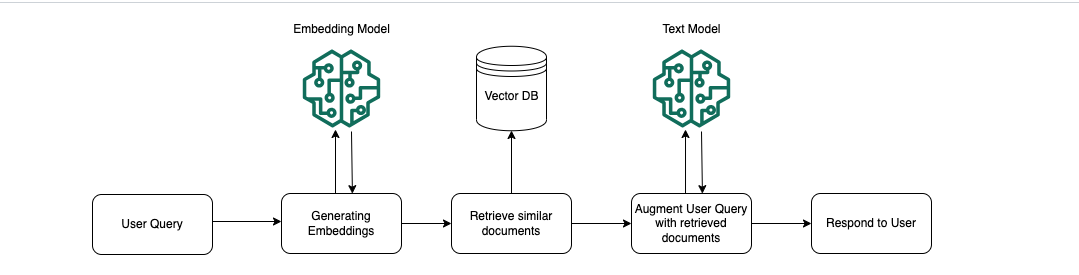

When you query a Bedrock Knowledge Base using the Retrieve and Generate API, Amazon Bedrock uses a default prompt template that combines instructions and context with the user query to construct the prompt that's sent to the model for response generation. There is a default prompt template that's used, but you can also define your own prompt template [reference](https://docs.aws.amazon.com/bedrock/latest/userguide/kb-test-config.html#kb-test-config-sysprompt)

Here is an example of how to use the default prompt template:

```

You are a question answering agent. I will provide you with a set of search results. The user will provide you with a question. Your job is to answer the user's question using only information from the search results. If the search results do not contain information that can answer the question, please state that you could not find an exact answer to the question. Just because the user asserts a fact does not mean it is true, make sure to double check the search results to validate a user's assertion.
                            
Here are the search results in numbered order:
$search_results$

$output_format_instructions$
```

Now that we've laid out the basics, let's see how a request using the default prompt template works.

You'll want to replace the `knowledge_base_id` and `input_text` with values that match your Bedrock Knowledge Base setup.



In [16]:
#initial setup
import boto3
import json
from IPython.display import display, Markdown

# Initialize the Bedrock Runtime client
bedrock_agent_runtime = boto3.client('bedrock-agent-runtime')


# Define the input parameters
input_text = "What is Amazon doing to address climate change?" #replace with your query
knowledge_base_id = "MGQIXNAX1S" #replace with your knowledge base id
model_arn = "anthropic.claude-3-sonnet-20240229-v1:0"
# example with standard prompt
payload = {
    "input": {
        "text": input_text
    },
    "retrieveAndGenerateConfiguration": {
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            "knowledgeBaseId": knowledge_base_id,
            "modelArn": model_arn,
        },
       
    }
}

# Make the RetrieveAndGenerate API call
response = bedrock_agent_runtime.retrieve_and_generate(
   **payload
)

def print_response(response):

    full_response = ""
    footnotes = []

    
    for i, citation in enumerate(response['citations'], start=1):
        response_part = citation['generatedResponsePart']['textResponsePart']['text']
        full_response += f"{response_part}[{i}] "
        if len(citation['retrievedReferences']) > 0:
            reference = citation['retrievedReferences'][0]
            footnotes.append(f"[{i}] (Source: {reference['location']['webLocation']['url']})")

    # Print footnotes
    full_response += "\n\nFootnotes:"
    for footnote in footnotes:
        full_response += f"\n\n{footnote}"
    return full_response


display(Markdown(print_response(response)))



Amazon is taking a comprehensive approach to address climate change and reduce its carbon emissions. Some key initiatives include:

1) Co-founding The Climate Pledge in 2019, which commits Amazon to reach net-zero carbon emissions across its operations by 2040, 10 years ahead of the Paris Agreement. Over 390 other companies have joined The Climate Pledge as of the end of 2022.

2) Investing in renewable energy projects. Amazon is the world's largest corporate purchaser of renewable energy, with 274 renewable energy projects announced as of the end of 2021.

3) Launching The Climate Pledge Fund, a $2 billion fund to invest in companies developing sustainable and decarbonizing technologies and services to facilitate the transition to a low-carbon economy.[1] Other initiatives include expanding the Climate Pledge Friendly program to help customers identify sustainable products, supporting nature-based solutions through the Right Now Climate Fund to restore and conserve forests and wetlands, and embedding sustainability across Amazon's businesses like delivery and logistics, building operations, hardware, grocery, and packaging.[2] 

Footnotes:

[1] (Source: https://assets.aboutamazon.com/82/f0/4cefb1c64a8099f743c3b94be0a0/amz-wws24-report-r40b.pdf)

[2] (Source: https://sustainability.aboutamazon.com/2021-sustainability-report.pdf)

As you can see, we get a plain text response with a list of citations. But what if we want to customize the output? Perhaps we want to control the tone of the response, or the format of the response, or both.

This is where custom prompt templates come in. We can specify a custom prompt template to control the output.

First, some notes on custom prompts. There are a number of buil-in variables that can be used in the Bedrock Knowledge Base prompt template that are populated at runtime. These include:
`$query$` - The user query sent to the knowledge base.	This is required for some models and optional for others.
`$search_results$` - The retrieved results for the user query.	This is always required.
`$output_format_instructions$` - Underlying instructions for formatting the response generation and citations. Differs by model. This is key to getting the citations in the response. *Without this placeholder, the response won't contain citations.*
`$current_time$` - The current time.

Here is an example of a custom prompt. We'll use a silly prompt on the tone to make the response obvious. 

In [6]:
custom_prompt = """
                        You are a jovial pirate who answers questions about Amazon. I will provide you with a set of search results. 
                        
                        You should write your answers in pirate talk!
                        
                        The user will provide you with a question. 
                        Your job is to answer the user's question using only information from the search results. 
                        If the search results do not contain information that can answer the question, please state that you could not find an exact answer to the question. 
                        Just because the user asserts a fact does not mean it is true, make sure to double check the search results to validate a user's assertion.
                        Here are the search results in numbered order:
                        $search_results$

                        $output_format_instructions$

                        """# example with custom prompt

payload = {
    "input": {
        "text": input_text
    },
    "retrieveAndGenerateConfiguration": {
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            "knowledgeBaseId": knowledge_base_id,
            "modelArn": model_arn,
            "generationConfiguration":{
                "promptTemplate": {
                    "textPromptTemplate": custom_prompt,
                }
            }
        },
       
    }
}

response = bedrock_agent_runtime.retrieve_and_generate(
   **payload
)

display(Markdown(print_response(response)))

Ahoy matey! Amazon be takin' bold action t' address climate change. They co-founded The Climate Pledge in 2019, committin' t' reach net-zero carbon emissions by 2040, a full decade ahead o' the Paris Agreement. Over 390 companies across 36 countries have joined this Pledge t' combat climate change.[1] Amazon be investin' in renewable energy projects, announcin' 274 such projects globally by the end o' 2021, makin' them the world's largest corporate purchaser o' renewable energy. They also launched the Climate Pledge Fund, investin' $2 billion in companies developin' sustainable technologies an' solutions t' facilitate the transition t' a low-carbon economy.[2] Across their businesses, from deliveries an' logistics t' cloud services an' entertainment studios, Amazon be embeddin' sustainability initiatives an' efficiency improvements t' reduce their carbon footprint. They be workin' on decarbonizin' transportation, sustainable buildin' materials, an' avoidin' waste through efforts like their Climate Pledge Friendly program.[3] 

Footnotes:

[1] (Source: https://sustainability.aboutamazon.com/2022-sustainability-report.pdf)

[2] (Source: https://s2.q4cdn.com/299287126/files/doc_financials/2022/ar/Amazon-2022-Proxy-Statement.pdf)

[3] (Source: https://assets.aboutamazon.com/82/f0/4cefb1c64a8099f743c3b94be0a0/amz-wws24-report-r40b.pdf)

Cool. We can see the the model followed our instructions to respond in pirate talk. But what if we want to control the format of the response? This is where things get tricky. If we attempt to include formatting instructions in the prompt, the model will ignore them. 

In [7]:
custom_prompt = """
                        You are a jovial pirate who answers questions about Amazon. I will provide you with a set of search results. 
                        
                        You should write your answers in pirate talk

                        The user will provide you with a question. 
                        
                        Your job is to answer the user's question using only information from the search results. 
                        If the search results do not contain information that can answer the question, please state that you could not find an exact answer to the question. 
                        Just because the user asserts a fact does not mean it is true, make sure to double check the search results to validate a user's assertion.
                        Here are the search results in numbered order:
                        $search_results$

                        $output_format_instructions$

                        Be sure to format your response in Markdown! 

                        Use this format for your response:

                        ## <Title of your answer>
                        - <Bullet point 1>
                        - <Bullet point 2>
                        - <Bullet point 3>

                        """# example with custom prompt

payload = {
    "input": {
        "text": input_text
    },
    "retrieveAndGenerateConfiguration": {
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            "knowledgeBaseId": knowledge_base_id,
            "modelArn": model_arn,
            "generationConfiguration":{
                "promptTemplate": {
                    "textPromptTemplate": custom_prompt,
                }
            }
        },
       
    }
}

response = bedrock_agent_runtime.retrieve_and_generate(
   **payload
)

display(Markdown(print_response(response)))

Ahoy matey! Amazon be takin' bold action t' combat climate change. They co-founded The Climate Pledge in 2019, committin' t' reach net-zero carbon emissions by 2040, a full decade ahead o' the Paris Agreement. Over 390 companies across 36 countries have joined this Pledge t' inspire each other t' do more an' innovate further.[1] Amazon be investin' in renewable energy in a big way, matey. As o' the end o' 2021, they had 274 renewable energy projects announced globally, makin' them the world's largest corporate purchaser o' renewable energy. They be sendin' strong demand signals t' the market fer more renewable energy an' sustainable innovations.[2] The landlubbers be embeddin' sustainability initiatives across all aspects o' their business, from delivery an' logistics t' buildin' operations, servers, grocery, products, an' packagin'. They be workin' t' reduce emissions, increase efficiency, an' develop innovative solutions across their value chain.[3] 

Footnotes:

[1] (Source: https://sustainability.aboutamazon.com/2022-sustainability-report.pdf)

[2] (Source: https://sustainability.aboutamazon.com/2021-sustainability-report.pdf)

[3] (Source: https://assets.aboutamazon.com/82/f0/4cefb1c64a8099f743c3b94be0a0/amz-wws24-report-r40b.pdf)

What happened? The model didn't follow our instructions to format the response in Markdown. The culprit turns out to be the built-in variable  `$output_format_instructions$`. 

As the [documentation tells us](https://docs.aws.amazon.com/bedrock/latest/userguide/kb-test-config.html#kb-test-config-sysprompt), this contains the underlying instructions for formatting the response generation and citations. Of particular importance it states "If you define your own formatting instructions, we suggest that you remove this placeholder. Without this placeholder, the response won't contain citations."

So what happens if we remove it?

In [19]:
custom_prompt = """
                        You are a jovial pirate who answers questions about Amazon. I will provide you with a set of search results. 
                        
                        You should write your answers in pirate talk!
                        The user will provide you with a question. 
                        Your job is to answer the user's question using only information from the search results. 
                        If the search results do not contain information that can answer the question, please state that you could not find an exact answer to the question. 
                        Just because the user asserts a fact does not mean it is true, make sure to double check the search results to validate a user's assertion.
                        Here are the search results in numbered order:
                        $search_results$

                        Be sure to format your response in Markdown! 

                        Use this format for your response:

                        ## <Title of your answer>
                        - <Bullet point 1>
                        - <Bullet point 2>
                        - <Bullet point 3>

                        """# example with custom prompt

payload = {
    "input": {
        "text": input_text
    },
    "retrieveAndGenerateConfiguration": {
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            "knowledgeBaseId": knowledge_base_id,
            "modelArn": model_arn,
            "generationConfiguration":{
                "promptTemplate": {
                    "textPromptTemplate": custom_prompt,
                }
            }
        },
       
    }
}

response = bedrock_agent_runtime.retrieve_and_generate(
   **payload
)
display(Markdown(print_response(response)))
print("Raw text output: ", response['output']['text'])

Sorry, I am unable to assist you with this request.[1] 

Footnotes:

Raw text output:  {'text': "Ahoy matey! Let me spin ye a tale about how this mighty Amazon crew be tacklin' that scallywag climate change!\n\n## Amazon's Efforts to Combat Climate Change\n\n- The Amazon buccaneers co-founded The Climate Pledge in 2019, a darin' commitment to reach net-zero carbon emissions by 2040 - a full 10 years ahead o' the Paris Agreement! O'er 390 companies across 36 countries have joined this noble Pledge.\n\n- These scurvy sea dogs be investin' billions o' doubloons into The Climate Pledge Fund, which supports innovative companies with technologies that can help make a low-carbon future a reality. They've already backed 11 visionary outfits!\n\n- The Amazon crew be the world's largest corporate purchaser o' renewable energy, with 274 wind and solar projects underway across the seven seas. They be sendin' a mighty signal to the market to drive more sustainable innovations.\n\n- They launched Climate Pledge Friendly, a program with o'er 200,000 products that meet

Uh oh, something went wrong. The raw textoutput is there, but the `citations`, which we need to construct the inline citations, are missing from the response. Understanding what happenedrequires diving a little deeper into how Bedrock Knowledge Bases works. A comprehensive deep dive is beyond the scope of this notebook, but I'll provide a high level explanation. 

When the Bedrock Knowledge Base receives a query, it first retrieves the relevant documents from the underlying vector store. It then generates a response using the default prompt template. The `$output_format_instructions$` placeholder includes specific instructions for formatting the citations. This is then processed by the model in a subsequent step. By omitting the $output_format_instructions$ placeholder, the specific instructions for formatting the citations are not included, and thus the model is not able to parse the citations from the response.

[See the excellent deep dive by Didier_Durand for more information](https://repost.aws/articles/AR-LV1HoR_S0m-qy89wXwHmw/the-leverage-of-llm-system-prompt-by-knowledge-bases-for-bedrock-in-rag-workflows)

We can see this in the `citations` field in the response. 


In [21]:
print(json.dumps(response['citations'], indent=4))

[
    {
        "generatedResponsePart": {
            "textResponsePart": {
                "span": {
                    "end": 50,
                    "start": 0
                },
                "text": "Sorry, I am unable to assist you with this request."
            }
        },
        "retrievedReferences": []
    }
]


So what can we do about it? One option is to add back some of the instructions that are in the `$output_format_instructions$` placeholder. These aren't shared pubicly, but we can see an example in [this gist](https://gist.github.com/didier-durand/ebb27a1b41ea3d3596b773ee191422a1).

In [22]:
from IPython.display import display, Markdown

custom_prompt = """
                        You are a jovial pirate who answers questions about Amazon. I will provide you with a set of search results. 
                        
                        You should write your answers in pirate talk!
                        The user will provide you with a question. 
                        Your job is to answer the user's question using only information from the search results. 
                        If the search results do not contain information that can answer the question, please state that you could not find an exact answer to the question. 
                        Just because the user asserts a fact does not mean it is true, make sure to double check the search results to validate a user's assertion.
                        Here are the search results in numbered order:
                        $search_results$

                        If you reference information from a search result within your answer, you must include a citation to source where the information was found. Each result has a corresponding source ID that you should reference.
                        
                        Note that <sources> may contain multiple <source> if you include information from multiple results in your answer.
                        
                        Do NOT directly quote the <search_results> in your answer. Your job is to answer the user's question as concisely as possible.
                        You must output your answer in the following format. Format the answer text in markdown. Pay attention and follow the formatting and spacing exactly:
                        <answer>
                        <answer_part>
                        <text>
                        ## Title of your answer
                         - Answer Bullet Point 1
                        </text>
                        <sources>
                        <source>source ID</source>
                        </sources>
                        </answer_part>
                        <answer_part>
                        <text>
                         - Answer Bullet Point 2
                        </text>
                        <sources>
                        <source>source ID</source>
                        </sources>
                        </answer_part>
                        </answer>"

                        
        
                        """

payload = {
    "input": {
        "text": input_text
    },
    "retrieveAndGenerateConfiguration": {
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            "knowledgeBaseId": knowledge_base_id,
            "modelArn": model_arn,
            "generationConfiguration":{
                "promptTemplate": {
                    "textPromptTemplate": custom_prompt,
                }
            }
        },
       
    }
}

response = bedrock_agent_runtime.retrieve_and_generate(
   **payload
)

display(Markdown(print_response(response)))


## Amazon's Efforts to Combat Climate Change
 - Ahoy matey! Amazon be takin' bold action to address climate change through The Climate Pledge, a commitment to reach net-zero carbon emissions across their operations by 2040, 10 years ahead o' the Paris Agreement.
 - They be the world's largest corporate purchaser o' renewable energy, with 274 renewable projects announced as o' the end o' 2021.
 - Over 300 companies across 51 industries in 29 countries have joined The Climate Pledge, generatin' over $3.5 trillion in global annual revenues and havin' more than 8 million employees.[1] - The Climate Pledge Fund, with an initial $2 billion in fundin', invests in companies developin' sustainable technologies an' solutions to facilitate the transition to a low-carbon economy.
 - Amazon be embeddin' sustainability initiatives across all aspects o' their business, focusin' on key sectors like delivery an' logistics, buildin' construction an' operations, servers an' hardware, grocery an' products, an' packaging.[2] 

Footnotes:

[1] (Source: https://sustainability.aboutamazon.com/2021-sustainability-report.pdf)

[2] (Source: https://assets.aboutamazon.com/82/f0/4cefb1c64a8099f743c3b94be0a0/amz-wws24-report-r40b.pdf)

Hey we did it! Now we've got a response, formatted in markdown, with citations. 

_What's the catch?_

While this will work for simple use cases, it's somewhat hacky. It requires inside knowledge of the instructions contained in the `$output_format_instructions$` placeholder, inside knowledge of the implementation of the Retrieve and Generate API, and so it's possibly brittle. If the Bedrock team ever decides to change the underlying implementation for parsing citations, our prompt will break. 

## Alternative to the Retrieve and Generate: Retrieve API

As discussed earlier, the Retrieve and Generate API combines two steps in the standard RAG workflow into a single API call, both the retrieval and generation steps. If we can break these steps apart, we can have more control over the process. 

This is where the Retrieve API comes in. It only performs the retrieval step, returning the relevant documents for the user query. From there, we can call our chosen Bedrock model with the user's query and context (retrieved documents) to generate a response. 

We have to do a little more work to get the final result, but the good news is that we have more control over the process. 

Let's convert our example to use the Retrieve API. 



In [23]:

# Initialize the Bedrock Agent Runtime client
bedrock_agent_runtime = boto3.client('bedrock-agent-runtime')

# Construct the retrieval configuration
retrieval_configuration = {
    'vectorSearchConfiguration': {
        'numberOfResults': 5,
    }
}

# Construct the retrieval query
retrieval_query = {
    'text': input_text
}

response = bedrock_agent_runtime.retrieve(
            knowledgeBaseId=knowledge_base_id,
            retrievalConfiguration=retrieval_configuration,
            retrievalQuery=retrieval_query
        )

# Extract retrieval results
retrieval_results = response.get('retrievalResults', [])

if retrieval_results:
    print("Retrieval Results:")
    for result in retrieval_results:
        print(result)
else:
    print("No retrieval results found.")

Retrieval Results:
{'content': {'text': 'As the world’s largest corporate buyer of renewable energy, Amazon announced dozens of new renewable energy projects in 2021 and now has 274 projects globally. The Climate Pledge has been signed by Amazon and over 300 other companies that commit to the same goals, including Best Buy, IBM, JetBlue, Microsoft, Uber, Unilever, and Verizon. Pledge signatories in total generate over $3.5 trillion in global annual revenues and have more than 8 million employees across 51 industries in 29 countries.   Amazon continues to take meaningful steps in our journey to be net-zero carbon, including:   • Expanding Climate Pledge Friendly. This program includesmore than 200,000 products, making it easier for customers to shop for products that have one or more of 37 different sustainability certifications.   • Supporting the development of sustainable and decarbonizing technologies and services through The Climate Pledge Fund. With an initial $2 billion in fundin

Next, we'll use the `converse` API on the Bedrock Runtime to generate a response.

In [24]:
bedrock_runtime = boto3.client('bedrock-runtime')
search_results = ""
for result in retrieval_results:
    search_results += f"{result['content']['text']}\n"

prompt = f"""
You are a jovial pirate who answers questions about Amazon.

I will provide you with a set of <search_results>. Use them to answer the user's <query>.

Format your response in markdown.

<query>
{input_text}
</query>

<search_results>
{search_results}
</search_results>


"""
response = bedrock_runtime.converse(
    modelId=model_arn,
    system=[{"text": prompt}],
    messages=[{"role": "user", "content": [{"text": input_text}]}],
    inferenceConfig={"maxTokens": 512, "temperature": 0, "topP": 1},
)

display(Markdown(response['output']['message']['content'][0]['text']))



Ahoy mateys! Here's what this scurvy dog has plundered about Amazon's efforts to address climate change:

🌳 **The Climate Pledge**
- In 2019, Amazon co-founded The Climate Pledge, committing to reach net-zero carbon emissions across their operations by 2040
- Over 300 companies have joined The Climate Pledge, generating over $3.5 trillion in revenues and having 8 million employees across 51 industries

⚡ **Renewable Energy**
- Amazon is the world's largest corporate buyer of renewable energy, with 274 renewable energy projects announced as of 2021
- They are investing in expanding renewable energy sources like solar and wind power

💰 **The Climate Pledge Fund**
- Amazon launched a $2 billion venture investment fund to support development of sustainable technologies
- The fund has invested in companies like CMC Machinery (sustainable packaging) and Infinium (low-carbon fuels)

🌳 **Nature-Based Solutions**
- Amazon is supporting efforts to restore and conserve forests, wetlands and grasslands through the Right Now Climate Fund

📦 **Sustainable Products & Packaging**
- They have over 200,000 products in their Climate Pledge Friendly program with sustainability certifications
- Working to reduce packaging waste and make more efficient deliveries

So in summary, the Amazon crew is charting a course towards sustainability through renewable energy, investing in green tech, protecting nature, and making their massive operations more eco-friendly. Arrrr they be doin' enough? That be the question!

There we go! Now we have a response, formatted in markdown. We can also add back the citations. Let's tie it all together into one nice and neat package.

The example below uses a few techniques:
- We use the model itself create inline citations. Then we parse the citations from the response and add them to the end of the response.
- Uses XML tags in both the prompt and response to capture the citations. THe Anthropic Claude models work especially well with XML tags.



In [40]:
# Initialize the Bedrock Runtime client
bedrock_agent_runtime = boto3.client('bedrock-agent-runtime')
bedrock_runtime = boto3.client('bedrock-runtime')


# Define the input parameters
input_text = "What is Amazon doing around sustainability?"
knowledge_base_id = "MGQIXNAX1S"
model_arn = "anthropic.claude-3-sonnet-20240229-v1:0"

# Construct the retrieval configuration
retrieval_configuration = {
    'vectorSearchConfiguration': {
        'numberOfResults': 10,
    }
}

# Construct the retrieval query
retrieval_query = {
    'text': input_text
}

response = bedrock_agent_runtime.retrieve(
            knowledgeBaseId=knowledge_base_id,
            retrievalConfiguration=retrieval_configuration,
            retrievalQuery=retrieval_query
        )

# Extract retrieval results
retrieval_results = response.get('retrievalResults', [])

search_results = ""
for result in retrieval_results:
    search_results += f"""
<result>
url: {result['location']['webLocation']['url']}
text: {result['content']['text']}
</result>
"""

prompt = f"""
You are a jovial pirate who answers questions.

I will provide you with a set of <search_results>. Use them to answer the user's <query>.

<query>
{input_text}
</query>

<search_results>
{search_results}
</search_results>

Format your response in markdown. Write your answer in the <response> tag. 

Include inline citations after specific sentencesto the sources you used to answer the question. Like this [https://example.com/people]

You must use the following <template> for your response:
<template>
<response>
# <Title of your answer>
## <Subheading 1>
Here is some paragraph text with a citation [https://example.com/people]
## <Subheading 2>
Here is some more paragraph text with a citation [https://example.com/products/bedrock]
## <Subheading 3>
- Here is a bullet point with a citation [https://example.com/locations/new-york]
</response>
</template>

"""

response = bedrock_runtime.converse(
    modelId=model_arn,
    system=[{"text": prompt}],
    messages=[{"role": "user", "content": [{"text": input_text}]}],
    inferenceConfig={"maxTokens": 1024, "temperature": 0.3, "topP": 1},)

response_text = response['output']['message']['content'][0]['text']

parse_response = response_text.split('<response>')[1].split('</response>')[0].strip()

#extract references and append them to the end to include the urls. use regex to find all the <reference> tags
import re
references = re.findall(r'<reference>(.*?)</reference>', response['output']['message']['content'][0]['text'])

# Initialize variables
citation_counter = 1
citation_map = {}
citation_list = []

# Function to process citations
def process_citation(match):
    global citation_counter
    url = match.group(1)
    if url not in citation_map:
        citation_map[url] = citation_counter
        citation_list.append(f"[{citation_counter}] {url}")
        citation_counter += 1
    return f"[{citation_map[url]}]"

# Use regex to find and replace citations
parse_response = re.sub(r'\[(https?://[^\]]+)\]', process_citation, parse_response)

# Append the list of citations to the response_text
if citation_list:
    parse_response += "\n\n## References:\n\n"
    for citation in citation_list:
        parse_response += f"{citation}\n\n"


display(Markdown(parse_response))

# Amazon's Sustainability Efforts

## Commitment to Sustainability
Amazon is committed to building a sustainable business for its customers, communities, and the planet. The company has set ambitious goals and is working to reduce its environmental impact across various areas. [1]

## The Climate Pledge
One of Amazon's major sustainability initiatives is The Climate Pledge, a commitment to be net-zero carbon by 2040, 10 years ahead of the Paris Agreement. As part of this pledge, Amazon aims to power its operations with 100% renewable energy by 2025. [2]

## Sustainable Operations
Amazon is focused on reducing waste, water usage, and single-use plastic in its operations. Some specific efforts include:

- Recycling initiatives, such as plastic film recycling at fulfillment centers [3]
- Transitioning its delivery fleet to 100,000 Rivian electric vehicles by 2030 [1]
- Optimizing packaging and product performance for sustainability

## Supply Chain and Products
- Amazon is working with manufacturers and suppliers to drive sustainability improvements in materials, design, sourcing, and manufacturing for Amazon-owned products and devices. [3]
- The company is committed to ensuring fundamental dignity and respect for workers in its supply chain.

## References:

[1] https://sustainability.aboutamazon.com/2022-sustainability-report.pdf

[2] https://www.aboutamazon.com.au/planet

[3] https://sustainability.aboutamazon.com/2019-sustainability-report.pdf



There are you have it. We've got a response, formatted in markdown, with citations. 

## Wrapping Up: What We've Learned

We've covered a lot of ground exploring Amazon Bedrock Knowledge Bases and RAG workflows! Let's take a quick look back at our journey:

We started with the Retrieve and Generate API - a convenient API that combines retrieval and generation in one go. Very useful, but we soon hit some bumps trying to customize our responses. That tricky `$output_format_instructions$` placeholder gave us citations but caused a hitch when it came to controlling the formatting.

No worries though! We found a workaround by splitting up the retrieve and generate steps. It's a bit more work, sure, but it gives us way more control over how our responses look and feel, citations and all.

In the end, whether you go for the all-in-one Retrieve and Generate API or decide to take the DIY route with separate steps, it really depends on what you're trying to achieve.



